In [18]:
from pathlib import Path
import argparse
import os 
import numpy as np
# import pandas as pd
import math
from tqdm import tqdm
from PIL import Image, ImageDraw
from bs4 import BeautifulSoup
from imutils import paths

import threading

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # All optimization algos, SGD, Adam, etc
import torchvision.transforms as transforms # Transformations to perform on data set, in addition to obspy 
from torch.utils.data import DataLoader # For dataset management and to create mini batches
from pprint import pprint

import torchvision.datasets as datasets # Standard datasets to test out model

In [19]:
TRAIN_PATH = Path(r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train")
IMAGE_PATHS = list(paths.list_images(TRAIN_PATH))
print(len(IMAGE_PATHS))
len(list(TRAIN_PATH.glob("*")))
# DATA_PATH = r"C:\Users\wilso\Desktop\ML-Earthquake-source-physics-research\src\data extraction\wilson\data_ISC"

843


15

In [20]:
### Helper Functions ###
def read_xml(path):
    # load the annotation file, build the soup, and initialize our
    # list of ground-truth bounding boxes
    contents = open(path).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = []

    # extract the image dimensions
    w = int(soup.find("width").string)
    h = int(soup.find("height").string)

    # loop over all 'object' elements
    for o in soup.find_all("object"):
        # extract the label and bounding box coordinates
        label = o.find("name").string
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)

        # truncate any bounding box coordinates that may fall
        # outside the boundaries of the image
        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)
        
        # update our list of ground-truth bounding boxes
        gtBoxes.append((xMin, yMin, xMax, yMax))
    return gtBoxes

02_down


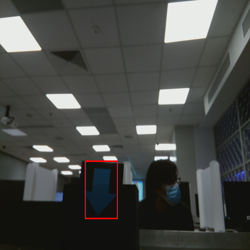

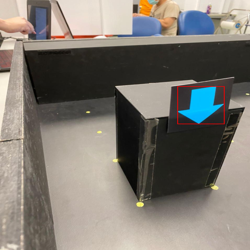

In [21]:
### Display bbox ###
image_path_sample_ls = IMAGE_PATHS[100:102]

prev_img_class = ""
for (i, image_path) in enumerate(image_path_sample_ls):
    img_fname = image_path.split(os.path.sep)[-1]
    img_fname = img_fname[:img_fname.rfind(".")]
    img_class = image_path.split(os.path.sep)[-3]
    if img_class != prev_img_class:
        print(img_class) 
    
    img_path = Path(os.path.join(TRAIN_PATH, img_class, "images", img_fname + ".jpg"))
    bbox_path = Path(os.path.join(TRAIN_PATH, img_class, "annotations", img_fname + ".xml"))

    img = Image.open(img_path) 
    draw = ImageDraw.Draw(img)

    bboxes = read_xml(bbox_path)
    # The box contains the upper left corner (x, y) coordinates then width and height. 
    # So we need to change these to (x1, y1) and (x2, y2) where they are the upper left and lower right corners 
    for bbox in bboxes: 
        x, y, w, h = bbox 
        draw.rectangle(bbox, outline="red", width=3) 
    img = img.resize((250, 250))
    prev_img_class = img_class
    display(img)

# EfficientDet from [link](https://github.com/rwightman/efficientdet-pytorch)

In [ ]:
# Hyperparameters
lr = 0.0002
batch_size = 64
image_size = 64 #
channels_img = 1
channels_noise = 256
num_epochs = 10

features_d = 16 # may want to set larger
features_g = 16 # may want to set larger

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")